In [4]:
# Threshold based on mean and standard deviation (does not work well)

import numpy as np
import pandas as pd
from scipy.spatial import distance
from tqdm import trange


In [5]:

# Load the database from an Excel file into a pandas DataFrame
df = pd.read_excel('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/database.xlsx')

# Extract the relevant columns from the DataFrame
filenames = df['Slp filename'].values
dev_days = df['Dev Day'].values

# Extract the day number from the 'Dev Day' column
day_numbers = [int(day[1:]) for day in dev_days]

# Determine the maximum day number
max_day_number = max(day_numbers)

# Initialize an empty numpy array to store the distance traveled per day for each animal
num_days = max_day_number - 15 + 1
num_animals = 5
distance_per_day = np.zeros((num_days, num_animals))

# Iterate over each row in the DataFrame
for i in trange(len(df)):
    filename = filenames[i]
    try:
        animal_data = np.load('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/features/'+filename.replace('.slp','_spine_nohuddle.npy'))
    except:
        # print(f'Missing: {filename}')
        animal_data = np.zeros((28802, 6, 2))
    dev_day = day_numbers[i]

    # Calculate the distance traveled per day for each animal
    for animal_index in range(num_animals):
        positions = animal_data[:, animal_index]
        centroid_diff = np.diff(positions, axis=0)
        # Filter out jitter by considering only actual movement
        threshold = np.nanmean(centroid_diff) + 3 * np.nanstd(centroid_diff)
        actual_movement = centroid_diff[np.abs(centroid_diff) > threshold]
        # Calculate the distance traveled using Euclidean distance
        dist = np.sum(distance.cdist(actual_movement[:-1, np.newaxis], actual_movement[1:, np.newaxis]))
        distance_per_day[dev_day - 15, animal_index] += dist

# Print the distance traveled per day for each animal
for dev_day in range(15, max_day_number + 1):
    # print(f'Day P{dev_day}:')
    for animal_index in range(num_animals):
        distance_traveled = distance_per_day[dev_day - 15, animal_index]
        # print(f'Animal {animal_index + 1}: {distance_traveled:.2f} units')
        
        


print ("DONE")

100%|█████████████████████████████████████████| 991/991 [00:19<00:00, 51.15it/s]

DONE


In [21]:
# Minimum and maximum thresholds based on pixels

import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

min_thresh = 3
max_thresh = 50
px_per_m = 2000

# Load the database from an Excel file into a pandas DataFrame
df = pd.read_excel('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/database.xlsx')

# Extract the relevant columns from the DataFrame
filenames = df['Slp filename'].values
dev_days = df['Dev Day'].values

# Extract the day number from the 'Dev Day' column
day_numbers = [int(day[1:]) for day in dev_days]

# Determine the maximum day number
max_day_number = max(day_numbers)

# Initialize an empty numpy array to store the distance traveled per day for each animal
num_days = max_day_number - 15 + 1
num_animals = 6
distance_per_day = np.zeros((num_days, num_animals))
window_size = 11
poly_order = 2

min_dist = 3
max_dist = 50

import scipy
import scipy.signal
from scipy import signal

# Iterate over each row in the DataFrame
for i in trange(len(df)):
    filename = filenames[i]
    try:
        animal_data = np.load('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/features/'+filename.replace('.slp','_spine_nohuddle.npy'))
    except:
        print(f'Missing: {filename}')
        animal_data = np.zeros((28802, 6, 2))
    dev_day = day_numbers[i]

    # Calculate the distance traveled per day for each animal
    for animal_index in range(num_animals):
        try:
            positions = animal_data[:, animal_index]
            
            # filter positions
            positions[:,0] = scipy.signal.savgol_filter(positions[:, 0], window_size, poly_order)
            positions[:,1] = scipy.signal.savgol_filter(positions[:, 0], window_size, poly_order)
            
            #
            #print ("Positions: ", positions)
            
            # 
            centroid_diff = positions[1:]-positions[:-1]
           # print ("centroid diff: ", centroid_diff)
            
            
            # Calculate the distance between consecutive points
            distances = np.linalg.norm(centroid_diff, axis=1)
           # print ("distances: ", distances)
            
            # Filter out movements less than the minimum threshold (3 units) and greater than the maximum threshold (50 units)
            idx = np.where(distances<=min_dist)[0]
            idx2 = np.where(distances>=max_dist)[0]
            
            idx = np.hstack((idx,idx2))            
            distances = distances[idx]
            
            
            # Convert the actual_movement from pixels to centimeters
            distances = distances / px_per_m
            
            # Calculate the distance traveled using Euclidean distance
            # dist = np.nansum(distance.cdist(actual_movement_cm[:-1], actual_movement_cm[1:]))
            dist = np.nansum(distances)
            
            #print ("animal ", animal_index, " , travelled: ", dist, "meteres in ~20mins")
            distance_per_day[dev_day - 15, animal_index] += dist
        
        #
        #else:
        except IndexError:
            # Handle cases where the array doesn't have enough animals
            print(f"Array {filename} doesn't have enough animals.")
            
       # break
   # break

  3%|█▎                                        | 32/991 [00:00<00:26, 36.07it/s]

Missing: 2020_07_20_19_55_21_569517_compressed_Day.slp
Missing: 2020_07_20_19_55_21_569517_compressed_Night.slp


  4%|█▋                                        | 40/991 [00:01<00:26, 36.03it/s]

Array 2020_07_20_22_52_47_231851_compressed_Night.slp doesn't have enough animals.
Array 2020_07_21_01_27_58_698136_compressed_Night.slp doesn't have enough animals.


  7%|██▉                                       | 68/991 [00:01<00:25, 36.67it/s]

Array 2020_07_21_08_29_09_286453_compressed_Day.slp doesn't have enough animals.
Array 2020_07_21_09_35_36_986659_compressed_Day.slp doesn't have enough animals.


 10%|████                                      | 96/991 [00:02<00:25, 35.72it/s]

Missing: 2020_07_21_19_55_36_310972_compressed_Day.slp
Missing: 2020_07_21_19_55_36_310972_compressed_Night.slp


 17%|██████▊                                  | 164/991 [00:04<00:23, 35.36it/s]

Missing: 2020_07_22_19_56_32_711641_compressed_Day.slp
Missing: 2020_07_22_19_56_32_711641_compressed_Night.slp


 17%|███████                                  | 172/991 [00:04<00:22, 35.83it/s]

Array 2020_07_22_22_31_53_393146_compressed_Night.slp doesn't have enough animals.


 20%|████████                                 | 196/991 [00:05<00:21, 36.41it/s]

Missing: 2020_07_23_07_46_39_462276_compressed_Day.slp
Missing: 2020_07_23_07_46_39_462276_compressed_Night.slp


 23%|█████████▌                               | 232/991 [00:06<00:20, 36.22it/s]

Missing: 2020_07_23_19_58_03_909312_compressed_Day.slp
Missing: 2020_07_23_19_58_03_909312_compressed_Night.slp


 27%|██████████▉                              | 264/991 [00:07<00:20, 36.22it/s]

Missing: 2020_07_24_07_48_00_521958_compressed_Day.slp
Missing: 2020_07_24_07_48_00_521958_compressed_Night.slp


 30%|████████████▏                            | 296/991 [00:08<00:19, 35.73it/s]

Missing: 2020_07_24_19_59_37_489342_compressed_Day.slp
Missing: 2020_07_24_19_59_37_489342_compressed_Night.slp


 34%|█████████████▋                           | 332/991 [00:09<00:17, 37.33it/s]

Missing: 2020_07_25_07_49_45_729250_compressed_Day.slp
Missing: 2020_07_25_07_49_45_729250_compressed_Night.slp
Array 2020_07_25_08_56_15_908311_compressed_Day.slp doesn't have enough animals.


 37%|███████████████                          | 364/991 [00:10<00:17, 36.82it/s]

Missing: 2020_07_25_20_01_48_433012_compressed_Day.slp
Missing: 2020_07_25_20_01_48_433012_compressed_Night.slp


 40%|████████████████▍                        | 396/991 [00:10<00:16, 35.99it/s]

Missing: 2020_07_26_07_51_47_287474_compressed_Day.slp
Missing: 2020_07_26_07_51_47_287474_compressed_Night.slp


 44%|█████████████████▊                       | 432/991 [00:11<00:15, 35.74it/s]

Missing: 2020_07_26_20_03_58_248000_compressed_Day.slp
Missing: 2020_07_26_20_03_58_248000_compressed_Night.slp


 47%|███████████████████▏                     | 464/991 [00:12<00:14, 36.60it/s]

Missing: 2020_07_27_07_54_02_236260_compressed_Day.slp
Missing: 2020_07_27_07_54_02_236260_compressed_Night.slp


 50%|████████████████████▌                    | 496/991 [00:13<00:14, 34.85it/s]

Missing: 2020_07_27_20_06_22_603634_compressed_Day.slp
Missing: 2020_07_27_20_06_22_603634_compressed_Night.slp


 54%|██████████████████████                   | 532/991 [00:14<00:12, 36.38it/s]

Missing: 2020_07_28_07_56_12_916962_compressed_Day.slp
Missing: 2020_07_28_07_56_12_916962_compressed_Night.slp


 60%|████████████████████████▋                | 596/991 [00:16<00:10, 36.40it/s]

Missing: 2020_07_29_07_58_52_895618_compressed_Day.slp
Missing: 2020_07_29_07_58_52_895618_compressed_Night.slp


 66%|███████████████████████████▏             | 656/991 [00:18<00:09, 34.86it/s]

Missing: 2020_07_30_07_58_21_812233_compressed_Day.slp
Missing: 2020_07_30_07_58_21_812233_compressed_Night.slp


 69%|████████████████████████████▍            | 688/991 [00:19<00:08, 35.83it/s]

Missing: 2020_07_30_19_47_56_767380_compressed_Day.slp
Missing: 2020_07_30_19_47_56_767380_compressed_Night.slp


 73%|█████████████████████████████▉           | 724/991 [00:20<00:07, 36.16it/s]

Missing: 2020_07_31_08_00_54_541312_compressed_Day.slp
Missing: 2020_07_31_08_00_54_541312_compressed_Night.slp


 76%|███████████████████████████████▎         | 756/991 [00:20<00:06, 35.29it/s]

Missing: 2020_07_31_19_53_05_251829_compressed_Day.slp
Missing: 2020_07_31_19_53_05_251829_compressed_Night.slp


 80%|████████████████████████████████▊        | 792/991 [00:21<00:05, 35.94it/s]

Missing: 2020_08_01_08_05_28_550500_compressed_Day.slp
Missing: 2020_08_01_08_05_28_550500_compressed_Night.slp


 83%|██████████████████████████████████       | 824/991 [00:22<00:04, 35.62it/s]

Missing: 2020_08_01_20_04_11_490071_compressed_Day.slp
Missing: 2020_08_01_20_04_11_490071_compressed_Night.slp


 86%|███████████████████████████████████▍     | 856/991 [00:23<00:03, 36.25it/s]

Missing: 2020_08_02_07_55_16_153343_compressed_Day.slp
Missing: 2020_08_02_07_55_16_153343_compressed_Night.slp


 90%|████████████████████████████████████▋    | 888/991 [00:24<00:02, 36.36it/s]

Missing: 2020_08_02_19_54_32_204143_compressed_Day.slp
Missing: 2020_08_02_19_54_32_204143_compressed_Night.slp


 93%|██████████████████████████████████████▏  | 924/991 [00:25<00:01, 36.13it/s]

Missing: 2020_08_03_08_06_52_830453_compressed_Day.slp
Missing: 2020_08_03_08_06_52_830453_compressed_Night.slp


 96%|███████████████████████████████████████▌ | 956/991 [00:26<00:01, 33.94it/s]

Missing: 2020_08_03_19_57_26_087619_compressed_Day.slp
Missing: 2020_08_03_19_57_26_087619_compressed_Night.slp


100%|████████████████████████████████████████▉| 988/991 [00:27<00:00, 36.52it/s]

Missing: 2020_08_04_07_48_11_839158_compressed_Day.slp
Missing: 2020_08_04_07_48_11_839158_compressed_Night.slp


100%|█████████████████████████████████████████| 991/991 [00:27<00:00, 36.01it/s]


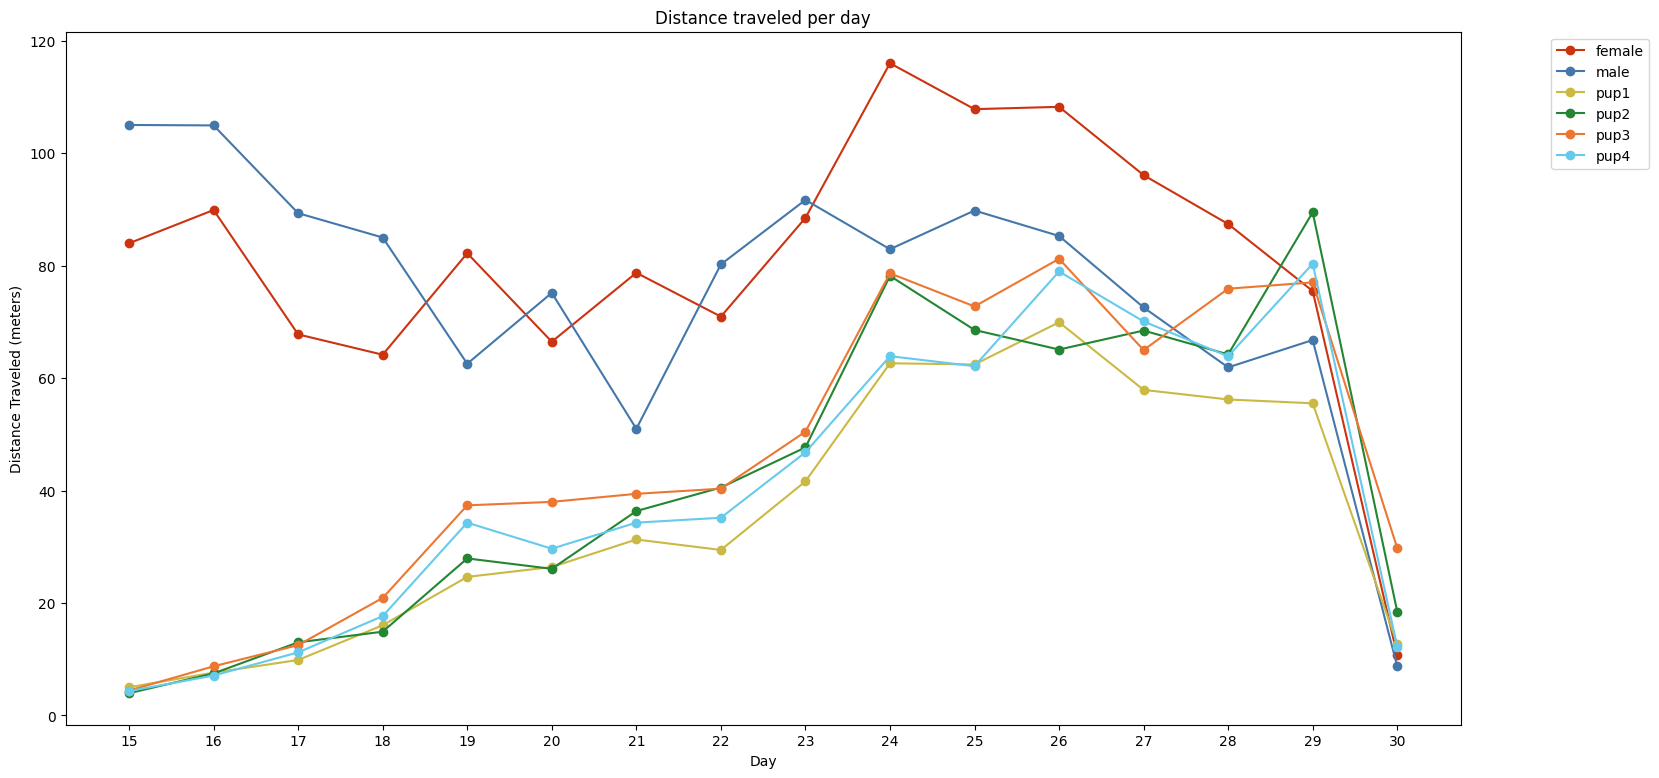

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))

colors = ['#cb3311', '#4477aa', '#cab944', '#228633', '#ec7733', '#66caec']
animal_names = ['female', 'male', 'pup1', 'pup2', 'pup3', 'pup4']

days = np.arange(15,31)

# Plot the developmental trajectory of distance traveled per animal
for animal_index in range(num_animals):
    animal_distances = distance_per_day[:, animal_index]
    x = range(15, 15 + num_days)  # x-axis values (PDay)
    y = animal_distances  # y-axis values (distance traveled)

    plt.plot(x, y, color = colors[animal_index], marker = 'o', label=f'{animal_names[animal_index]}')

plt.xlabel('Day')
plt.ylabel('Distance Traveled (meters)')

plt.xticks(days)

plt.title('Distance traveled per day')

plt.legend(loc = 'upper right', bbox_to_anchor=(1.14, 1))

# plt.show()

plt.savefig('/home/cat/Downloads/distance_traveled_v3_pxs.png')


In [26]:
np.save('/home/cat/Downloads/distance.npy' , distance_per_day)

In [ ]:
# This counted the times an animal was detected ina  grid, but not movement between grids!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the database from an Excel file into a pandas DataFrame
df = pd.read_excel('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/database.xlsx')

# Extract the relevant columns from the DataFrame
filenames = df['Slp filename'].values
dev_days = df['Dev Day'].values

# Extract the day number from the 'Dev Day' column
day_numbers = [int(day[1:]) for day in dev_days]

# Determine the maximum day number
max_day_number = max(day_numbers)

# Define the grid size in cm
grid_size_cm = 4

# Calculate the grid size in pixels based on the video dimensions and grid size in cm
video_width_px = 900
video_height_px = 700
grid_size_px = grid_size_cm * 20  # Assuming 20 pixels/cm

# Calculate the number of grid squares in each dimension
num_grid_squares_x = int(video_width_px / grid_size_px)
num_grid_squares_y = int(video_height_px / grid_size_px)

# Initialize an empty numpy array to store the counts per grid square for each animal
num_days = max_day_number - 15 + 1
num_animals = 6
counts_per_grid_square = np.zeros((num_days, num_animals, num_grid_squares_y, num_grid_squares_x))

# Define a function to calculate the counts per grid square for a single row
def calculate_counts(row):
    filename = row['Slp filename']
    dev_day = int(row['Dev Day'][1:])
    try:
        animal_data = np.load('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/features/'+filename.replace('.slp','_spine_nohuddle.npy'))
    except:
        print(f'Missing: {filename}')
        animal_data = np.zeros((28802, 6, 2))
    
    for animal_index in range(num_animals):
        try:
            positions = animal_data[:, animal_index]
            centroid_diff = np.diff(positions, axis=0)

            # Iterate over the movements and increment the corresponding grid square counts
            for frame_index in range(1, len(positions)):
                movement = positions[frame_index] - positions[frame_index - 1]
                x, y = movement
                if 0 <= x < video_width_px and 0 <= y < video_height_px:
                    grid_square_x = int(x / grid_size_px)
                    grid_square_y = int(y / grid_size_px)
                    counts_per_grid_square[dev_day - 15, animal_index, grid_square_y, grid_square_x] += 1

                    
        except IndexError:
            print(f"Array {filename} doesn't have enough animals.")

# Iterate over each row in the DataFrame and calculate the counts per grid square
for _, row in df.iterrows():
    calculate_counts(row)

# Calculate the total distance traveled per animal per day by multiplying the counts by the grid size
total_distance_per_day = np.sum(counts_per_grid_square, axis=(2, 3))

In [ ]:
import numpy as np
import pandas as pd

# Set the grid size in pixels
grid_size_px = 20

# Load the Excel file into a DataFrame
df = pd.read_excel('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/database.xlsx')

# Determine the number of days and animals
num_days = df['Dev Day'].nunique()
num_animals = df['Animal Index'].nunique()

# Create an empty array to store the total distance traveled per animal per day
total_distance_per_day = np.zeros((num_days, num_animals))

# Iterate over each row in the DataFrame and calculate the counts per grid square
for _, row in df.iterrows():
    dev_day = int(row['Dev Day'])
    animal_index = int(row['Animal Index'])
    positions = row['Slp filename']

    # Iterate over the movements and increment the corresponding grid square counts
    for frame_index in range(1, len(positions)):
        current_position = positions[frame_index]
        previous_position = positions[frame_index - 1]
        
        # Calculate the grid square indices for the current and previous positions
        current_grid_x = int(current_position[0] / grid_size_px)
        current_grid_y = int(current_position[1] / grid_size_px)
        previous_grid_x = int(previous_position[0] / grid_size_px)
        previous_grid_y = int(previous_position[1] / grid_size_px)

        # Check if the animal has moved to a different grid square
        if current_grid_x != previous_grid_x or current_grid_y != previous_grid_y:
            total_distance_per_day[dev_day - 15, animal_index] += 1

In [65]:
import numpy as np
import pandas as pd

# Load the Excel file into a DataFrame
df = pd.read_excel('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/database.xlsx')

# Set the grid size in pixels and cm
grid_size_px = 20  # 1cm grid size
grid_size_cm = 1

# Create an empty array to store the counts per grid square
num_days = df['Dev Day'].max() - df['Dev Day'].min() + 1
num_animals = np.max(df['Animal Index']) + 1
grid_counts = np.zeros((num_days, num_animals, grid_size_px, grid_size_px))

# Iterate over each row in the DataFrame and calculate the counts per grid square
for _, row in df.iterrows():
    dev_day = int(row['Dev Day'])
    animal_index = int(row['Animal Index'])
    filename = row['Slp filename']

    try:
        animal_data = np.load('/mnt/b3a68699-495d-4ebb-9ab1-ac74f11c68c5/gerbil/cohort2/features/' + filename.replace('.slp', '_spine_nohuddle.npy'))
    except:
        print(f'Missing: {filename}')
        animal_data = np.zeros((28802, 6, 2))

    positions = animal_data[:, :, :2]

    # Calculate the counts per grid square
    for animal_positions in positions:
        # Iterate over the movements and update the counts per grid square
        for frame_index in range(1, len(animal_positions)):
            current_position = animal_positions[frame_index]
            previous_position = animal_positions[frame_index - 1]

            # Calculate the movement in pixels
            movement_px = np.linalg.norm(current_position - previous_position)

            # Check if the animal has moved to a different grid square
            if movement_px > grid_size_px:
                # Convert movement to cm
                movement_cm = movement_px / grid_size_px * grid_size_cm

                # Update the counts for the corresponding day, animal, and grid square
                x = int(current_position[0] // grid_size_px)
                y = int(current_position[1] // grid_size_px)
                grid_counts[dev_day - df['Dev Day'].min(), animal_index, y, x] += 1

# Calculate the total distance traveled per animal per day by summing the counts and multiplying by the grid size
total_distance_per_day = np.sum(grid_counts, axis=(2, 3)) * grid_size_cm

TypeError: unsupported operand type(s) for -: 'str' and 'str'

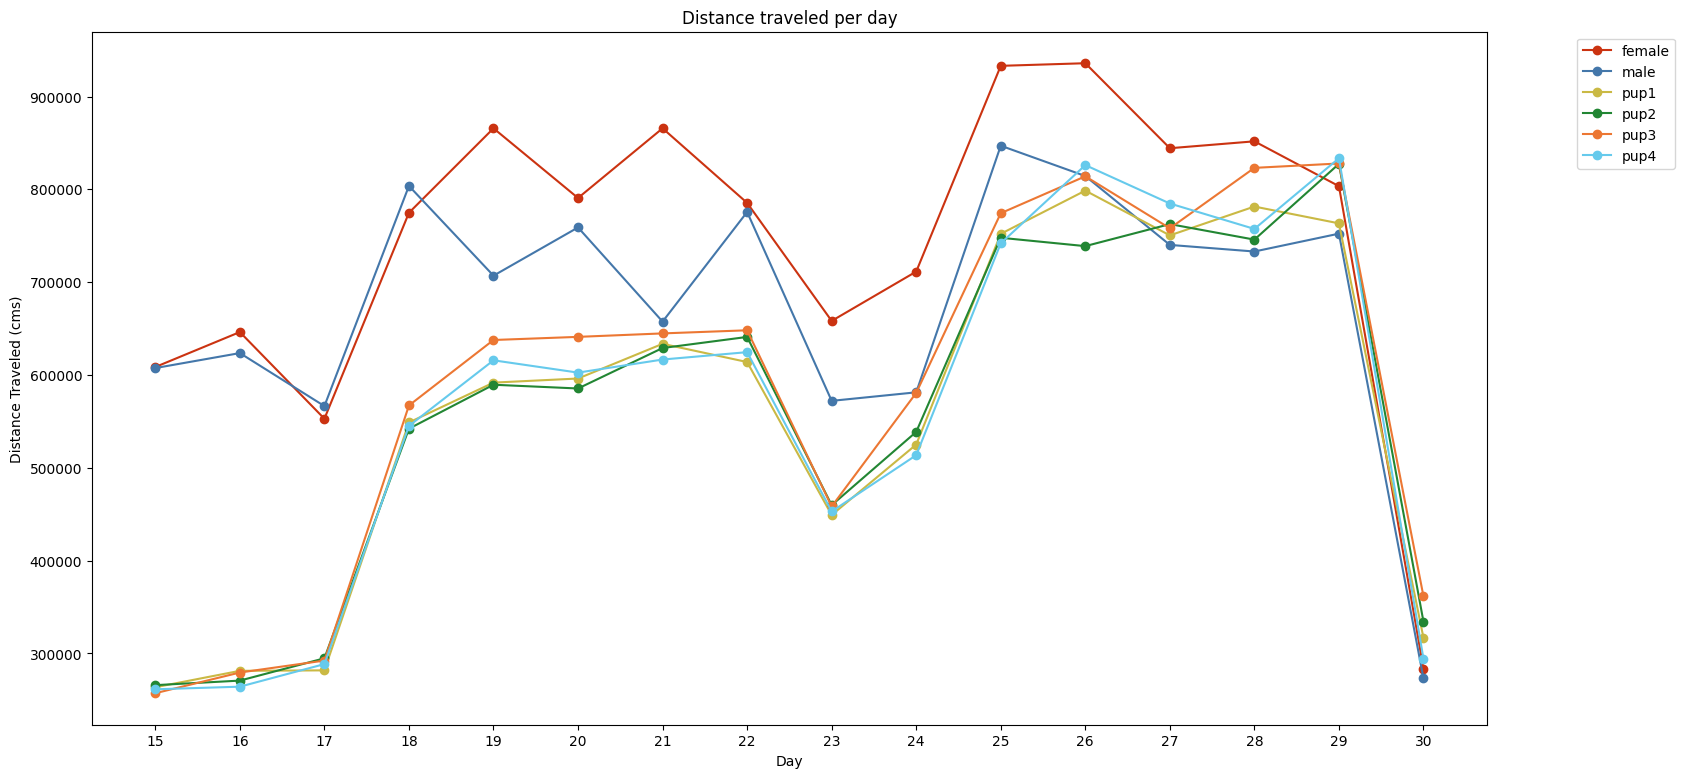

In [58]:
plt.figure(figsize = (18,9))

colors = ['#cb3311', '#4477aa', '#cab944', '#228633', '#ec7733', '#66caec']
animal_names = ['female', 'male', 'pup1', 'pup2', 'pup3', 'pup4']

days = np.arange(15,31)

for animal_index in range(num_animals):
    animal_distances = total_distance_per_day[:, animal_index]
    x = range(15, 15 + num_days)  # x-axis values (PDay)
    y = animal_distances * grid_size_cm  # Convert distances to centimeters

    plt.plot(x, y, color = colors[animal_index], marker = 'o', label=f'{animal_names[animal_index]}')

plt.xlabel('Day')
plt.ylabel('Distance Traveled (cms)')

plt.xticks(days)

plt.title('Distance traveled per day')

plt.legend(loc = 'upper right', bbox_to_anchor=(1.14, 1))

# plt.show()

plt.savefig('/home/cat/Downloads/distance_traveled_v5_grid(4cm).png')